## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

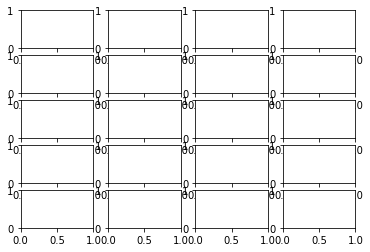

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

global out_img
global firstPass
global imgSize
global left_fit
global right_fit
global left_fitx
global right_fitx
global initialLeftRightFit
#last frame's fit lines
# variables to remember from first pass
initialLeftRightFit = tuple()
last_fit = tuple()
last_fitx = tuple()
#boolean for first pass
firstPass = False
ploty = np.empty(0)
imgSize = tuple()

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.subplots(5,4 )

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(corners)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
        
        
    
        
        
cv2.destroyAllWindows()

## And so on and so forth...

In [2]:
import os
# Performs the camera calibration and image undistortion 
#while not os.path.isfile("../camera_cal/calibration01.jpg"):
    #print('not present')

img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
#Undistorit this image
def undistort(img):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img



#ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
#print(corners)

In [ ]:
def corners_unwarp(img, nx, ny):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(nx,ny)
    Minv = cv2.getPerspectiveTransform(ny,nx)
    warped = cv2.warpPerspective(img,M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv



In [ ]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(200, 235)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output




In [ ]:
def LAB_Bthresh(img, thresh=(155,200)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    if np.max(b_channel) > 175:
       lab_b = b_channel*(255/np.max(b_channel))
    # 2) Apply a threshold to the L channel
    b_output = np.zeros_like(b_channel)
    b_output[((b_channel > thresh[0]) & (b_channel <= thresh[1]))] = 1
    return b_output



In [ ]:
def lane_pipeline(img, s_thresh=(190, 255)):
    #img = np.copy(img)
    #my_img = cv2.imread('./test_images/test2.jpg')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(my_img
    #Undistort
    h,w = img.shape[:2]
    #src1 = np.float32([[(imgSize[1]/4)-50,   imgSize[0]-20],[ imgSize[1]-80,   imgSize[0]-20],[  ((imgSize[1]/2)+140),   (2*imgSize[0]/3)],[  (.4*imgSize[1])-32,   (2*imgSize[0]/3)]])
    #dst1 = np.float32([[0,imgSize[0]],[imgSize[1],imgSize[0]],[imgSize[1],0],[0,0]])
    #src1 = np.float32(
    #[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    #[((img_size[0] / 6) - 10), img_size[1]],
    ##[(img_size[0] * 5 / 6) + 60, img_size[1]],
    #[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    #dst1 = np.float32(
    #[[(img_size[0] / 4), 0],
    #[(img_size[0] / 4), img_size[1]],
    #[(img_size[0] * 3 / 4), img_size[1]],
    #[(img_size[0] * 3 / 4), 0]])
    dst1 = np.float32([(450,0),
                 (w-450,0),
                 (450,h),
                (w-450,h)])
    src1 = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    #dst1 = np.float32([(450,0),
    #              (w-450,0),
    #              (450,h),
    #              (w-450,h)])
    
    img_undist = undistort(img)
    #Perspective transform 
    img, M, Minv = corners_unwarp(img_undist,src1,dst1)
    
    b_binary= LAB_Bthresh(img)
    # Threshold color channel
    l_binary = hls_select(img)
    
    color_binary = np.dstack(( np.zeros_like(b_binary), b_binary, l_binary)) * 255
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    return combined_binary, Minv

my_img = cv2.imread('./test_images/test2.jpg')
my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
#plt.imshow(my_img)    
result, Minv = lane_pipeline(my_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(my_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_radius(bin_img, left_val,right_val): #_fit, r_fit, l_lane_inds, r_lane_inds):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
        
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    left_val = left_val[0]*ploty**2 + left_val[1]*ploty + left_val[2]
    right_val = right_val[0]*ploty**2 + right_val[1]*ploty + right_val[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    #nonzero = bin_img.nonzero()
    #nonzeroy = np.array(nonzero[0])
    #nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    #leftx = nonzerox[l_lane_inds]
    #lefty = nonzeroy[l_lane_inds] 
    #rightx = nonzerox[r_lane_inds]
    #righty = nonzeroy[r_lane_inds]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_val*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_val*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
    left_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    #return left_curverad
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    #if r_fit is not None and l_fit is not None:
    car_position = bin_img.shape[1]/2
    l_fit_x_int = left_val[0]*h**2 + left_val[1]*h + left_val[2]
    r_fit_x_int = right_val[0]*h**2 + right_val[1]*h + right_val[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_rad, right_rad, center_dist



In [ ]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    #quadratic_coeff = 3e-4
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))*255
    
    l_fit = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    r_fit = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([l_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result



In [ ]:
def print_text(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    text = "radius of curvature: {:.2f}m; distance from center: {:.2f}m".format(curv_rad, center_dist)
    new_img =cv2.putText(new_img, text, (100,100), 2, 1, (200,255,0), 2)
    #direction = ''
    #if center_dist > 0:
    #    direction = 'right'
    #elif center_dist < 0:
    #    direction = 'left'
    #abs_center_dist = abs(center_dist)
    #text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    #cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img




In [ ]:
global initialLeftRightFit
global first_epoch 
first_epoch = False
initialLeftRightFit = tuple()
last_fit = tuple()
last_fitx = tuple()

def pipeline(Img):
    global out_img
    global first_epoch
    global imgSize
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global initialLeftRightFit
    global last_fit
    global last_fitx
    global ploty
    #first_epoch = False
    #plt.imshow(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img_bin, Minv = lane_pipeline(Img)
    Img = undistort(Img)
    #left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = find_window_centroids(Img_bin)
    if not first_epoch:
        nonzero = Img_bin.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        out_img = np.dstack((Img_bin,Img_bin, Img_bin))*255
        
        histogram = np.sum(Img_bin[img.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        quarter_point = np.int(midpoint//2)
        leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
        rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

        nwindows = 9
        # Set height of windows
        window_height = np.int(Img_bin.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 40
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Rectangle data for visualization
        rectangle_data = []

        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = Img_bin.shape[0] - (window+1)*window_height
            win_y_high = Img_bin.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            #rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_fit, right_fit = (None, None)
        # Fit a second order polynomial to each
        if len(leftx) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit = np.polyfit(righty, rightx, 2)
        last_fit = (left_fit,right_fit) #change
        initialLeftRightFit = (left_fit,right_fit) #change

        first_epoch= True #change
        ploty = np.linspace(0, Img_bin.shape[0]-1, Img_bin.shape[0] )
        if len(left_fit) != 0:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if len(right_fit) != 0:
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        last_fitx = (left_fitx,right_fitx) #change
                                   
        rad_l, rad_r, d_center = calc_radius(Img_bin, left_fit, right_fit)
        result = draw_lane(Img, Img_bin, left_fit, right_fit, Minv)
        
        
    else: #change
        nonzero = Img_bin.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80 
 
         # Use from first pass
        left_fit,right_fit = initialLeftRightFit[0],initialLeftRightFit[1]
        margin = 80
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each if every lane has enough pixels to form a lane
        if (leftx.size>50)and(lefty.size>50)and(rightx.size>50)and(righty.size>50):

            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            last_fit = (left_fit,right_fit)
        else:
            left_fit, right_fit = last_fit[0], last_fit[1]
        # Generate x and y values for plotting
        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((Img_bin, Img_bin, Img_bin))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
 
    ploty = np.linspace(0, Img_bin.shape[0]-1, Img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #rad_l, rad_r, d_center = calc_radius(Img_bin, left_fit, right_fit)
    #result = draw_lane(Img, Img_bin, left_fit, right_fit, Minv)

    warp_zero = np.zeros_like(Img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

     # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (Img.shape[1], Img.shape[0])) 

      # Combine the result with the original image
    result = cv2.addWeighted(Img, 1, newwarp, 0.3, 0)    

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    midx = 650

        ## RADIUS OF CURVATURE
    #Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        # radius of curvature
    rad_l = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    rad_r = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # in meters
    cv2.putText(result,'Radius of Curvature: Left= %.2fm' % rad_l + ',  Right= %.2fm' % rad_r ,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    left_pixX = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    right_pixX = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    d_center = ((left_pixX + right_pixX)/2 - midx) * xm_per_pix
    if d_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(d_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)                               
                                   
                                   
    #img_draw = print_text(Img_out1, (rad_l+rad_r)/2, d_center)
    return result
    #draw_data(original_img, curv_rad, center_dist)
#Img = cv2.imread('./test_images/test2.jpg')
#final_img = pipeline(Img) 
#plt.imshow(final_img)

In [ ]:

print(first_epoch)
from moviepy.editor import VideoFileClip
from IPython.display import HTML

source = VideoFileClip("./project_video.mp4")#.subclip(20, 25)
target = "project_video_output.mp4"

annotated = source.fl_image(pipeline)
%time annotated.write_videofile(target, audio=False)